In [6]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import cPickle as pickle
import tensorflow as tf
import gym
from matplotlib import pyplot as plt
# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
# gamma = 1-0.
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = True # resume from previous checkpoint?
# resume = False;
render = False
# render = True
backlen=20;

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(xrange(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}
def lookback(lst):
    lst = lst[-backlen:];
#     np.pad(lst,(20-lst.size,), 'constant', constant_values=0);
    if len(lst) != backlen:
        lst = [None]*(backlen-len(lst)) + lst;
    return(lst)

In [207]:
# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    pass
#     dAlg = tf_training_algorithm() 
#     oSaver = tf.train.Saver()
#     oSaver.restore(dAlg['oSess'], 'save.ckpt')
#     return {
#     'oSess': dAlg['oSess'],
#     #the other stuff I need from my algorithm, like my solution space etc
# }
else:
    tf.reset_default_graph()
    observations = tf.placeholder(tf.float32, [None,D] , name="input_x")
    W1 = tf.get_variable("W1", shape=[D, H],
               initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", shape=[H, 1],
               initializer=tf.contrib.layers.xavier_initializer())
#     Wt = tf.get_variable("Wt1", shape=[D, 1],
#            initializer=tf.contrib.layers.xavier_initializer())
    layer1 = tf.nn.relu(tf.matmul(observations,W1))
    score = tf.matmul(layer1,W2)
    probability = tf.nn.sigmoid(score)
#     timespan = 

    tvars = tf.trainable_variables()
    input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
    advantages = tf.placeholder(tf.float32,name="reward_signal")

    loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
    loss = -tf.reduce_mean(loglik * advantages) 
    newGrads = tf.gradients(loss,tvars)

    W1Grad = tf.placeholder(tf.float32,name="batch_grad1") # Placeholders to send the final gradients through when we update.
    W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
#     WtGrad = tf.placeholder(tf.float32,name="batch_gradt")
    
    batchGrad = [W1Grad,W2Grad]

    optimiser = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
#     batchGrads = optimiser.compute_gradients(loss,tvars)
#     updateGrads = optimiser.apply_gradients(zip(batchGrad,tvars))
    updateGrads = optimiser.apply_gradients(zip(newGrads,tvars))
    
def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(xrange(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}
def lookback(lst):
    lst = lst[-backlen:];
#     np.pad(lst,(20-lst.size,), 'constant', constant_values=0);
    if len(lst) != backlen:
        lst = [None]*(backlen-len(lst)) + lst;
    return(lst)

init = tf.global_variables_initializer();
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
ys=[];byss=[];rss=[];
running_reward = None
reward_sum = 0
episode_number = 0

[2017-06-01 23:12:17,436] Making new env: Pong-v0


In [7]:
ModelName = 'RL_pong_RMSprop'
ModelFile = 'Models/'+ModelName+'.ckpt';
# ModelName='save.ckpt'
# fname = 
with tf.Session() as sess:
    sess.run(init)
    gradBuffer = [np.zeros_like(v) for v in sess.run(tvars)]
#     grad_buffer = { k : np.zeros_like(v) for k,v in model.iteritems() } # update buffers that add up gradients over a batch
    if resume: 
        tf.reset_default_graph()
        oSaver = tf.train.Saver()
        oSaver.restore(sess,ModelFile)
    while True:
        if render: env.render()

        # preprocess the observation, set input to network to be difference image
        cur_x = prepro(observation)
        diff_x = cur_x - prev_x if prev_x is not None else np.zeros(D)
        prev_x = cur_x
        x = np.reshape(diff_x,[1,D]);
        # forward the policy network and sample an action from the returned probability
#         aprob, h = policy_forward(x)
        aprob = sess.run(probability,feed_dict={observations: x})
#         tdur = sess.run(waitingtime,feed_dict={observations: x})
        action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

        # record various intermediates (needed later for backprop)
        xs.append(x) # observation
        y = 1 if action == 2 else 0 # a "fake label"
        ys.append(y)

        # step the environment and get new measurements
        observation, reward, done, info = env.step(action)
        reward_sum += reward
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: # an episode finished
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
#             eph = np.vstack(hs)
#             epdlogp = np.vstack(dlogps)
            epy = np.vstack(ys);
            epr = np.vstack(drs)
            xs,hs,dlogps,drs,ys,tfps = [],[],[],[],[],[] # reset array memory
            # compute the discounted reward backwards through time
            discounted_epr = discount_rewards(epr)
            # standardize the rewards to be unit normal (helps control the gradient estimator variance)
            discounted_epr -= np.mean(discounted_epr)
            discounted_epr /= np.std(discounted_epr)


            tGrad = sess.run(newGrads,feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})

            for ix,grad in enumerate(tGrad):
                gradBuffer[ix] += grad
                
            # perform rmsprop parameter update every batch_size episodes
            if episode_number % batch_size == 0:
                sess.run(updateGrads,feed_dict={W1Grad: gradBuffer[0],W2Grad:gradBuffer[1]})
                for ix,grad in enumerate(gradBuffer):
                    gradBuffer[ix] = grad * 0
    
            # boring book-keeping
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            print 'resetting env. episode %d reward total was %f. running mean: %f' % (episode_number, reward_sum, running_reward)
            if episode_number % 30  == 29: 
                oSaver = tf.train.Saver()
                oSess = sess
                oSaver.save(oSess, ModelFile) 
#                 pickle.dump(tf, open('save.p', 'wb'))
            reward_sum = 0
            observation = env.reset() # reset env
            prev_x = None

        if reward != 0: # Pong has either +1 or -1 reward exactly when game ends. 
            bys=lookback(ys);
            byss.append(bys);
            rss.append(reward);
            if len(byss)-1 == 100:
                    byss.pop(0);
                    rss.pop(0);

            pass;
    #     print ('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!')

NameError: name 'tvars' is not defined

80

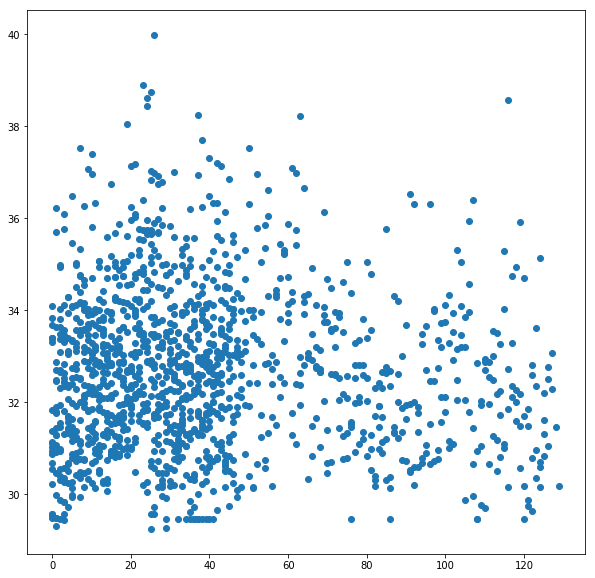

In [57]:
# discount_rewards(epdlogp)
x.size
%matplotlib inline
plt.close('all')
fig=plt.figure(figsize=[10,10])
ax1=plt.subplot()
# ax1.plot(time_epr)
ax1.scatter(time_epr,eptpred)
# ax1.set_xlim([0, 80])
# ax1.imshow(eph[:500,:500].T)
time_epr.size
# tpreds.size
D1

In [50]:
# model initialization
# resume = False;
resume = True;
render = False;
render = True;
H=5;
D1=80;D2=80;

def time_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        if r[t] != 0: running_add = -1 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add + 1;
        discounted_r[t] = running_add
    return discounted_r

D = 80 * 80 # input dimensionality: 80x80 grid
tf.reset_default_graph()
# if resume:
#     pass

# else:
#     observations = tf.placeholder(tf.float32, [None,D] , name="input_x")
#     W1 = tf.get_variable("W1", shape=[D, H],
#                initializer=tf.contrib.layers.xavier_initializer())
#     b1 = tf.constant(0.1, shape=[1,H]);
#     W2 = tf.get_variable("W2", shape=[H, 1],
#                initializer=tf.contrib.layers.xavier_initializer())
#     b2 = tf.constant(0.1, shape=[1,1]);
xinput = tf.placeholder(tf.float32, name="input_x")
observations = tf.reshape(xinput,[-1,D1,D2,1])
conv1 = tf.layers.conv2d(
  inputs=observations,
  filters=H,
  kernel_size=[5, 5],
  padding="same",
  activation=tf.nn.relu)
dense = tf.layers.dense(inputs=tf.reshape(conv1,[-1, D*H]), units=H, activation=tf.nn.relu)
dropout = dense;
#     logits = tf.layers.dense(inputs=dropout, units=10)
score = tf.layers.dense(inputs=dropout, units=1,activation = tf.identity)
tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
#     advantages = tf.placeholder(tf.float32,name="reward_signal")
rtime = tf.placeholder(tf.float32,name="reward_signal")

#     loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
loss = tf.reduce_mean(tf.square(score - rtime)) 
newGrads = tf.gradients(loss,tvars)

batchGrad = [];
for i,var in enumerate(tvars):
    exec('Grad%d'%i + ' = tf.placeholder(tf.float32)');
    exec('batchGrad += [Grad%d]'%i)


optimiser = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
#     batchGrad = optimiser.compute_gradients(loss,tvars);
batchGrad = newGrads;
updateGrads = optimiser.apply_gradients(zip(batchGrad,tvars))
init = tf.global_variables_initializer();

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
ys=[];byss=[];rss=[];tpreds=[];
running_reward = None
reward_sum = 0
episode_number = 0

[2017-06-02 10:35:58,402] Making new env: Pong-v0


In [184]:
# xinput.shape

TensorShape(None)

In [203]:


xinput = tf.placeholder(tf.float32 , name="input_x")
observations = tf.reshape(xinput,[-1,D1,D2,1])
conv1 = tf.layers.conv2d(
      inputs=observations,
      filters=10,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
# conv1
conv1 = tf.layers.conv2d(
  inputs=observations,
  filters=H,
  kernel_size=[5, 5],
  padding="same",
  activation=tf.nn.relu)
dense = tf.layers.dense(inputs=tf.reshape(conv1,[-1, D*H]), units=H, activation=tf.nn.relu)
dropout = dense;
#     logits = tf.layers.dense(inputs=dropout, units=10)
score = tf.layers.dense(inputs=dropout, units=1,activation = tf.identity)
# score
dense

<tf.Tensor 'dense_3/Relu:0' shape=(?, 5) dtype=float32>

In [ ]:
# resume
# oSaver.restore(sess,ModelFile)
# sess
all_vars
sess.close()
sess = tf.Session();
oSaver = tf.train.import_meta_graph(ModelFile+'.meta')    
oSaver.restore(sess,tf.train.latest_checkpoint('./Models/'))

#         sess.run(tf.global_variables_initializer())
all_vars = tf.get_collection('vars')

In [49]:
# all_vars
# tf.get_tensor_by

<function tensorflow.python.ops.variable_scope.get_variable>

In [56]:
ModelName = 'rtime_RL_pong_RMSprop'
ModelFile = 'Models/'+ModelName+'.ckpt';
render = False;
batch_size=1;
learning_rate = 1e-2

# ModelName='save.ckpt'
# fname = 
# with tf.Session() as sess:
# gdcmd='grad_dict = {'+','.join(['Grad%d: gradBuffer[%d]'%(i,i) for i,k in enumerate(tvars)])+'}';
while True:
    sess = tf.Session();
#     gradBuffer = [np.zeros_like(v) for v in sess.run(tvars)]
#     grad_buffer = { k : np.zeros_like(v) for k,v in model.iteritems() } # update buffers that add up gradients over a batch
    if resume: 
#         tf.train.import_meta_graph(ModelFile+'.meta')    
        oSaver = tf.train.Saver()
#         oSaver.restore(sess,ModelFile)
#         oSaver = tf.train.import_meta_graph(ModelFile+'.meta')    
        oSaver.restore(sess,tf.train.latest_checkpoint('./Models/'))
        
#         sess.run(tf.global_variables_initializer())
        all_vars = tf.get_collection('vars')
        for v in all_vars:
            v_ = sess.run(v)
            print(v_)
    else:
        sess.run(init)
    while True:
        if render: env.render()

        # preprocess the observation, set input to network to be difference image
        cur_x = prepro(observation)
        diff_x = cur_x - prev_x if prev_x is not None else np.zeros(D)
        prev_x = cur_x
        x = np.reshape(diff_x,[1,D1,D2,1]);
#         aprob = sess.run(probability,feed_dict={observations: x})
        aprob = 0.5;
        tpred = sess.run(score,feed_dict={observations: x})    
        action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

        # record various intermediates (needed later for backprop)
        xs.append(x) # observation
        y = 1 if action == 2 else 0 # a "fake label"
        ys.append(y)
        tpreds.append(tpred);

        # step the environment and get new measurements
        observation, reward, done, info = env.step(action)
        reward_sum += reward
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: # an episode finished
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys);
            epr = np.vstack(drs)
            eptpred=np.vstack(tpreds);
            xs,hs,dlogps,drs,ys,tpreds = [],[],[],[],[],[] # reset array memory
            
#             # compute the discounted reward backwards through time
#             discounted_epr = discount_rewards(epr)
#             # standardize the rewards to be unit normal (helps control the gradient estimator variance)
#             discounted_epr -= np.mean(discounted_epr)
#             discounted_epr /= np.std(discounted_epr)
            
            time_epr=time_rewards(epr);
#             curr_loss = sess.run(loss,feed_dict={xinput: epx, input_y: epy, rtime: time_epr});
            lst =  sess.run([loss,updateGrads],feed_dict={xinput: epx, input_y: epy, rtime: time_epr});
            curr_loss = lst[0];
#             curr_loss = sess.run(loss,feed_dict={xinput: epx, input_y: epy, rtime: time_epr});
            
#             tGrad = sess.run([loss,newGrads,updateGrads],feed_dict={xinput: epx, input_y: epy, rtime: time_epr});
#             for ix,grad in enumerate(tGrad):
#                 gradBuffer[ix] += grad
            
            # perform rmsprop parameter update every batch_size episodes
            if episode_number % batch_size == 0:
                pass
#                 grad_dict={varname:}
#                 exec(gdcmd);
#                 sess.run(updateGrads,feed_dict={Grad0: gradBuffer[0],W2Grad:gradBuffer[1]})
#                 sess.run(updateGrads)
#                 sess.run(updateGrads,feed_dict={newGrads:tGrad})
#                 sess.run(updateGrads,feed_dict={xinput: epx, input_y: epy, rtime: time_epr});
             
                
#                 gradBuffer = [np.zeros_like(v) for v in sess.run(tvars)]
    
            # boring book-keeping
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            print 'resetting env. episode %d reward total was %f. loss_func: %f' % (episode_number, reward_sum, curr_loss)
            if episode_number % 10  == 9: 
                oSaver = tf.train.Saver()
                oSess = sess
                oSaver.save(oSess, ModelFile) 
#                 pickle.dump(tf, open('save.p', 'wb'))
            reward_sum = 0
            observation = env.reset() # reset env
            prev_x = None

        if reward != 0: # Pong has either +1 or -1 reward exactly when game ends. 
            bys=lookback(ys);
            byss.append(bys);
            rss.append(reward);
            if len(byss)-1 == 100:
                    byss.pop(0);
                    rss.pop(0);

            pass;
    #     print ('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!')

INFO:tensorflow:Restoring parameters from ./Models/rtime_RL_pong_RMSprop.ckpt


[2017-06-02 11:09:57,953] Restoring parameters from ./Models/rtime_RL_pong_RMSprop.ckpt


resetting env. episode 4 reward total was -21.000000. loss_func: 504.453949
resetting env. episode 5 reward total was -21.000000. loss_func: 1411.307983
resetting env. episode 6 reward total was -20.000000. loss_func: 527.647583
resetting env. episode 7 reward total was -21.000000. loss_func: 748.551758
resetting env. episode 8 reward total was -17.000000. loss_func: 1002.213013
resetting env. episode 9 reward total was -21.000000. loss_func: 1821.181641
resetting env. episode 10 reward total was -21.000000. loss_func: 573.202881
resetting env. episode 11 reward total was -21.000000. loss_func: 1010.024292
resetting env. episode 12 reward total was -20.000000. loss_func: 2752.239990
resetting env. episode 13 reward total was -20.000000. loss_func: 1679.405762
resetting env. episode 14 reward total was -21.000000. loss_func: 1679.910278
resetting env. episode 15 reward total was -18.000000. loss_func: 1953.360107
resetting env. episode 16 reward total was -21.000000. loss_func: 941.0281

KeyboardInterrupt: 

In [6]:
# print(time_epr.ravel())
# time_epr
# tpreds
# H
# np.expand_dims(epx,1).shape
# curr_loss = sess.run(loss,feed_dict={xinput: epx, input_y: epy, rtime: time_epr});
# epx.shape
# tf.reshape(epy);
# D*H
oSaver = tf.train.Saver()
# oSess = sess
# oSaver.save(oSess, ModelFile)

ValueError: No variables to save